# Testing Refactored model

In [1]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import Model
from Model import FrequencyDependentModel
from Model.back_prop_utils import H_th_function, round_to_sig_figs, c, torch_unwrap
from Model.plotting_utils import plot_transfer, plot_comparison, plot_training_progress
from Model.loss_functions import loss, complex_transfer_loss, complex_real_imag_loss, log_complex_loss

# Testing AverageTransferFunctionModel Method

## Setup transfer function
We will setup a simulated experimental transfer function. This will not have noisy data between 0-0.3 THZ but we will treat it like it does in order to ensure the method is valid for experimental situations.

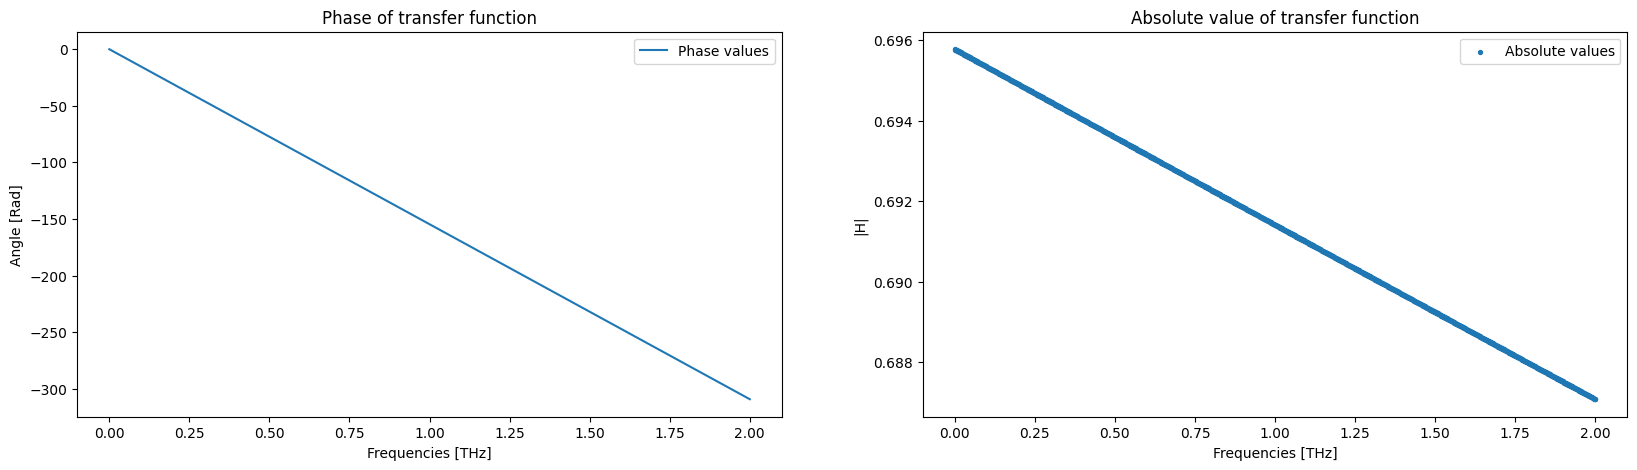

In [2]:
# Setup parameters
n = 3.46
k = -1e-4
thickness = 3 * 1e-3

# Setup frequency arrays
frequency_bounds = [0.3, 2]
full_w_THz = np.linspace(0,frequency_bounds[1], 1000)
full_w_THz = torch.tensor(full_w_THz, dtype=torch.float32)

# Convert to angular freqs for calcs
full_w = full_w_THz * 2 * np.pi * 1e12

n_complex = n + 1j*k

H_exp = H_th_function(n_complex, full_w,length=thickness)

H_exp_abs = torch.abs(H_exp)
H_exp_phi = torch_unwrap(torch.angle(H_exp))

plot_transfer(full_w_THz, H_exp_abs, H_exp_phi)

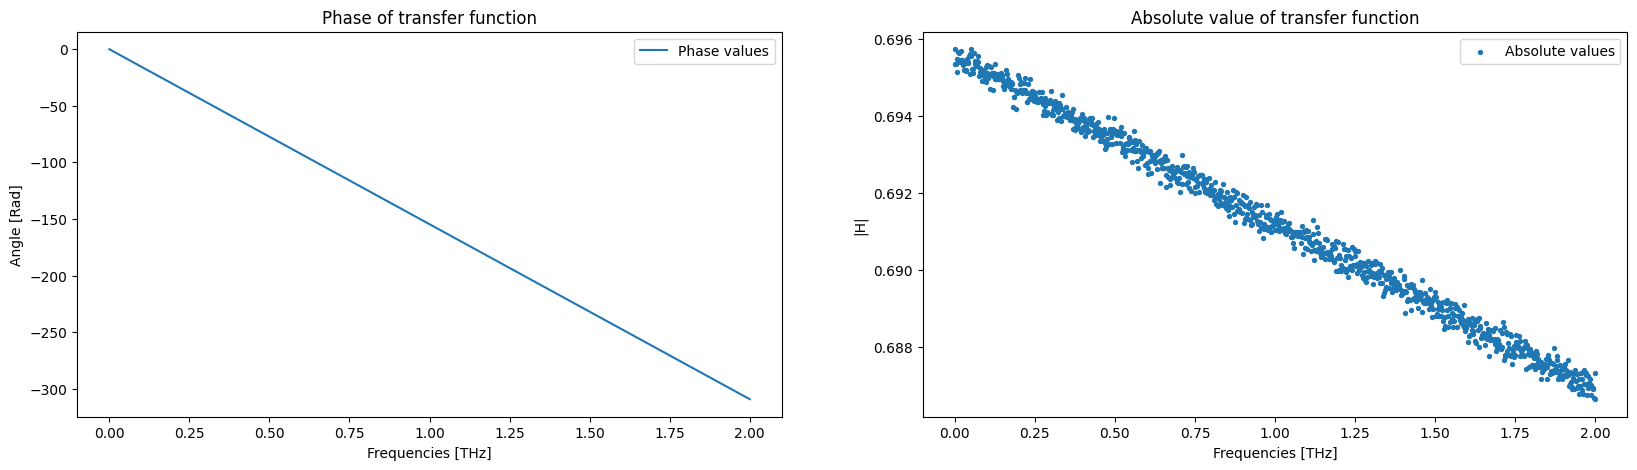

In [3]:
# Add noise to the system
noise = np.random.normal(-0.0002, 0.0002, size=len(H_exp_abs))
H_exp_abs += noise

plot_transfer(full_w_THz, H_exp_abs, H_exp_phi) 

## Initalize Model

In [4]:
# Setup frequencies and values over interested range, best done with pandas
data = {
    'frequencies': full_w,
    'frequencies_THz': full_w_THz,
    'Exp_abs': H_exp_abs,
    'Exp_phi': H_exp_phi
}

df = pd.DataFrame(data=data)
filter = df['frequencies_THz'] >= 0.3

w_fitting = df['frequencies'][filter].to_numpy()
w_fitting = torch.tensor(w_fitting, dtype=torch.float32)
abs_fitting = torch.tensor(df['Exp_abs'][filter].to_numpy(), dtype=torch.float32)
phi_fitting = torch.tensor(df['Exp_phi'][filter].to_numpy(), dtype=torch.float32)

df

,frequencies,frequencies_THz,Exp_abs,Exp_phi
0,0.000000e+00,0.000000,0.695360,0.000016
1,1.257895e+10,0.002002,0.695733,-0.309640
2,2.515790e+10,0.004004,0.695338,-0.619297
3,3.773685e+10,0.006006,0.695475,-0.928953
4,5.031580e+10,0.008008,0.695136,-1.238610
...,...,...,...,...
995,1.251605e+13,1.991992,0.686929,-308.108063
996,1.252863e+13,1.993994,0.686913,-308.417725
997,1.254121e+13,1.995996,0.686679,-308.727386
998,1.255379e+13,1.997998,0.686637,-309.037048


Epoch 0: Total Loss = 33.28279495239258, Learning Rate = 0.001
Epoch 1000: Total Loss = 0.5557677745819092, Learning Rate = 0.001
Epoch 2000: Total Loss = 0.11796821653842926, Learning Rate = 1e-05
Epoch 3000: Total Loss = 0.12021088600158691, Learning Rate = 1.0000000000000004e-08
Epoch 4000: Total Loss = 0.12021088600158691, Learning Rate = 1.0000000000000004e-08
Epoch 5000: Total Loss = 0.12021088600158691, Learning Rate = 1.0000000000000004e-08
Epoch 6000: Total Loss = 0.12021088600158691, Learning Rate = 1.0000000000000004e-08
Epoch 7000: Total Loss = 0.12021088600158691, Learning Rate = 1.0000000000000004e-08
Epoch 8000: Total Loss = 0.12021088600158691, Learning Rate = 1.0000000000000004e-08
Epoch 9000: Total Loss = 0.12021088600158691, Learning Rate = 1.0000000000000004e-08
Epoch 9999: Total Loss = 0.12021088600158691, Learning Rate = 1.0000000000000004e-08
Best parameters found (Lowest Loss: 0.0015495421830564737):
n: 3.4616541862487793
k: -0.00010030385601567104


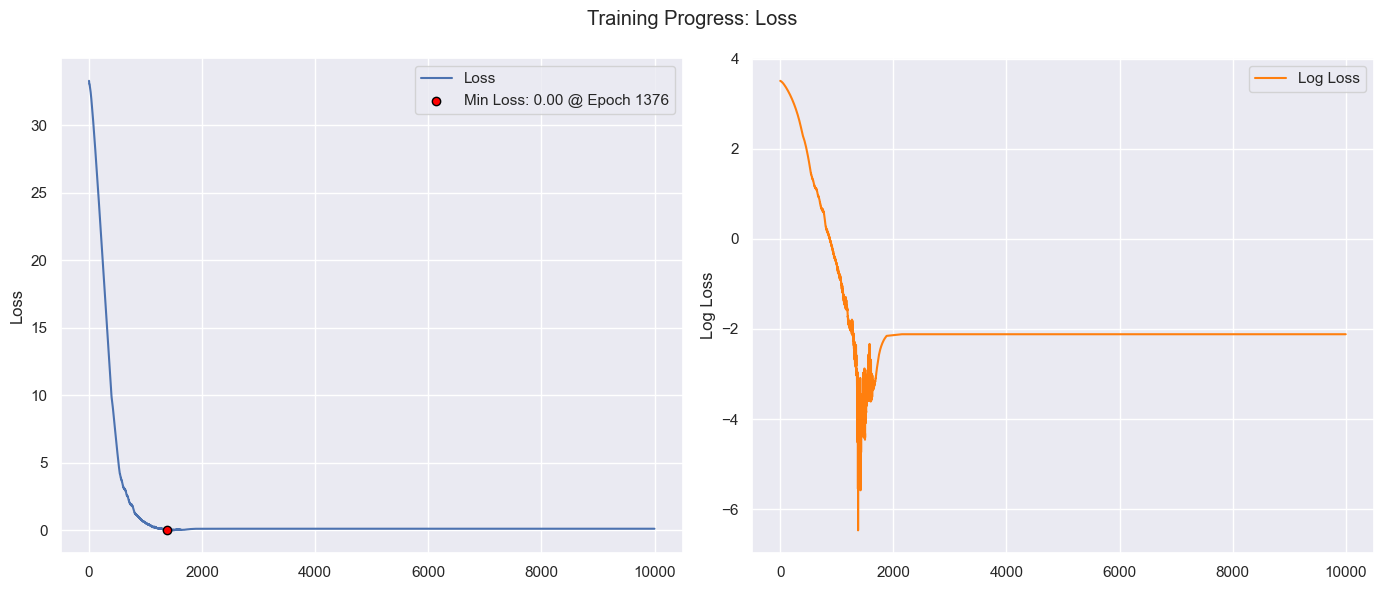

In [5]:
# Initialize model over the freqs range [0.3, 2]
avg_model = Model.AverageTransferFunctionModel(w_tensor=w_fitting, d=thickness, ICs_n=3, ICs_k=-0.001)

# Setup Optimizer and scheduler
optimizer = torch.optim.Adam(avg_model.parameters(), lr=1e-3)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.1, patience=250)

# Train model
avg_model.train_model(loss_fn=loss, H_values=abs_fitting, phi_values=phi_fitting, updates=1000, optimizer=optimizer, scheduler=scheduler)
avg_model.plot_training_curves()

In [6]:
avg_model.best_params

{'n': array(3.4616542, dtype=float32),
 'k': array(-0.0001003, dtype=float32),
 'loss': 0.0015495421830564737}

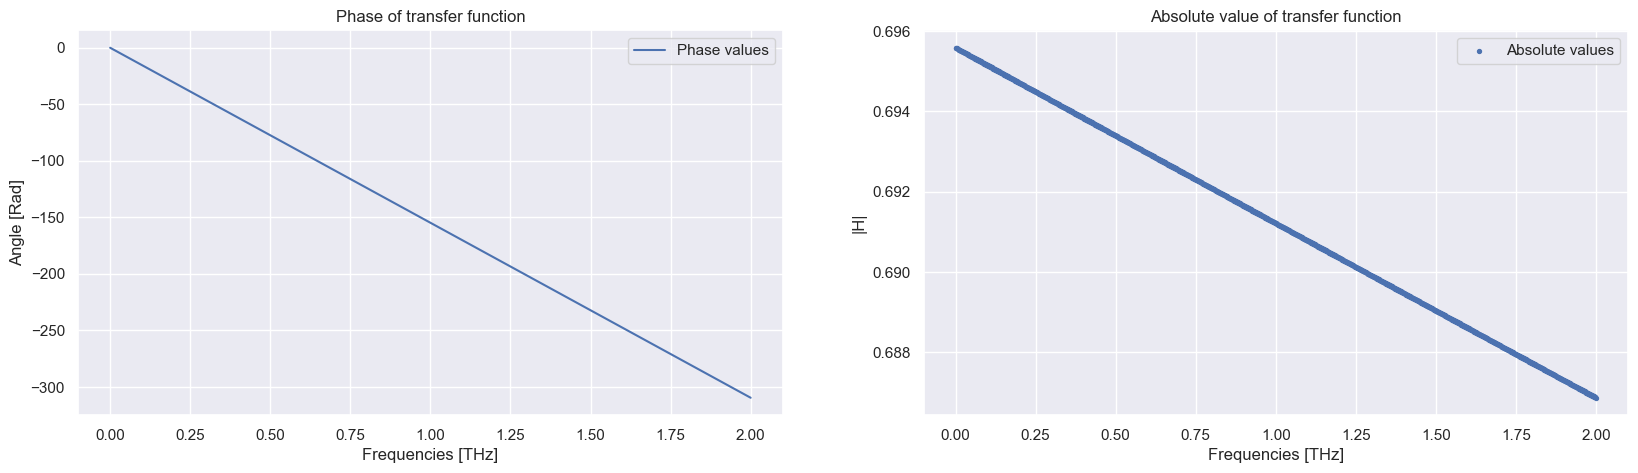

In [7]:
avg_complex_n = avg_model.best_params['n'] + 1j*avg_model.best_params['k']

recon_H = H_th_function(avg_complex_n, full_w, thickness)
recon_abs = torch.abs(recon_H)
recon_phi = torch_unwrap(torch.angle(recon_H))

plot_transfer(full_w_THz, recon_abs, recon_phi)

In [8]:
avg_model.n

Parameter containing:
tensor(3.4617, requires_grad=True)

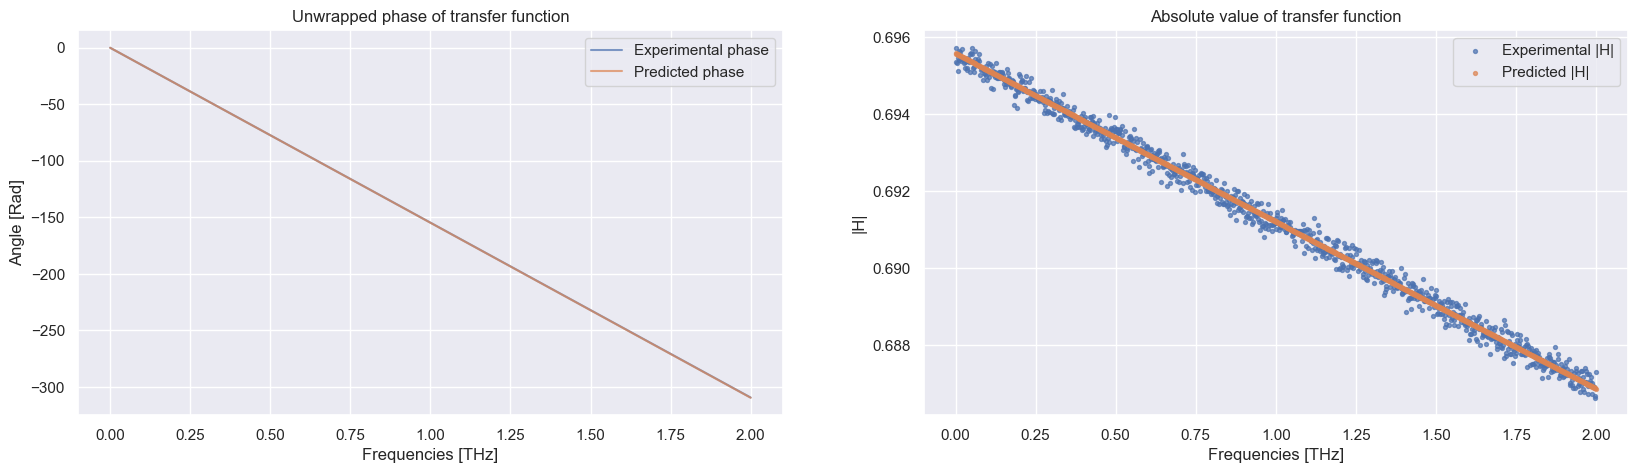

In [9]:
plot_comparison(full_w_THz, 
                exp_abs=H_exp_abs, exp_phase=H_exp_phi, 
                pred_abs=recon_abs, pred_phase=recon_phi
                )

# Test FrequencyDependentModel methods

## Set up Frequency dependent n & k and Transfer Function

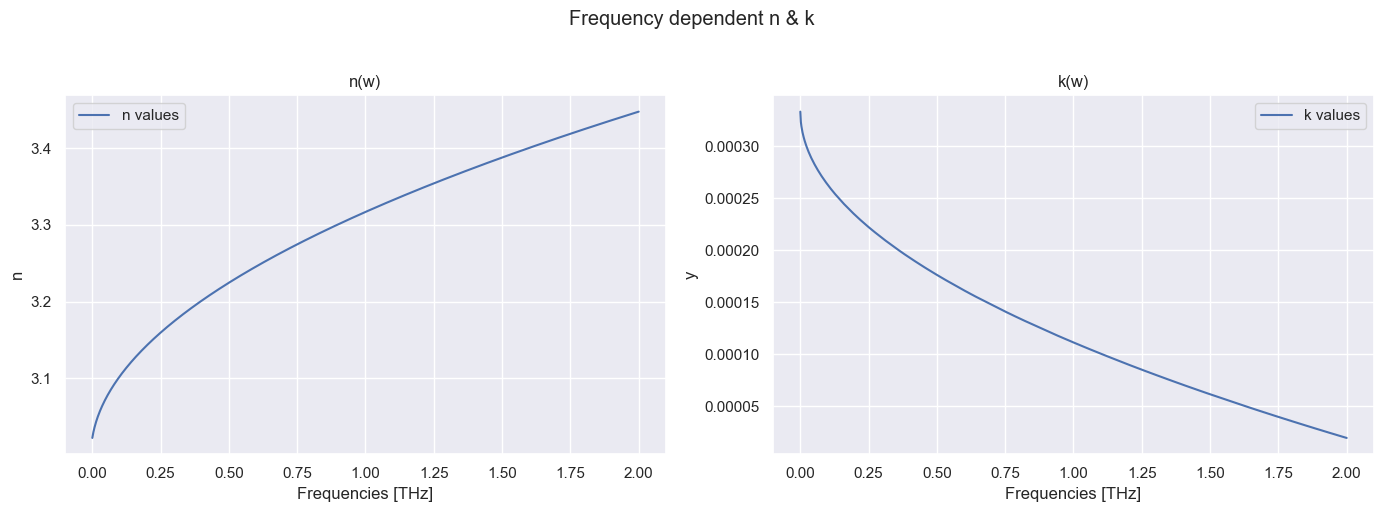

In [10]:
n = np.sqrt(0.1 * (full_w_THz + 0.005)) + 3
k = ((np.sqrt(0.000004 * full_w_THz) + 3)**-1) - 0.333

# Create the first subplot (assuming 'data1' is your first dataset)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# First plot: Approximate values of n from NR solution
sns.lineplot(x=full_w_THz, y=n, label="n values", ax=ax1)
ax1.set_title('n(w)')
ax1.yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
ax1.set_xlabel('Frequencies [THz]')
ax1.set_ylabel('n')

# Second plot (assuming 'data2' is your second dataset with x and y values)
sns.lineplot(x=full_w_THz, y=k, label="k values", ax=ax2)
ax2.set_title('k(w)')
ax2.yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
ax2.set_xlabel('Frequencies [THz]')
ax2.set_ylabel('y')

# Adjust layout and add main title if needed
plt.suptitle('Frequency dependent n & k', y=1.02)
plt.tight_layout()
plt.legend()
plt.show()

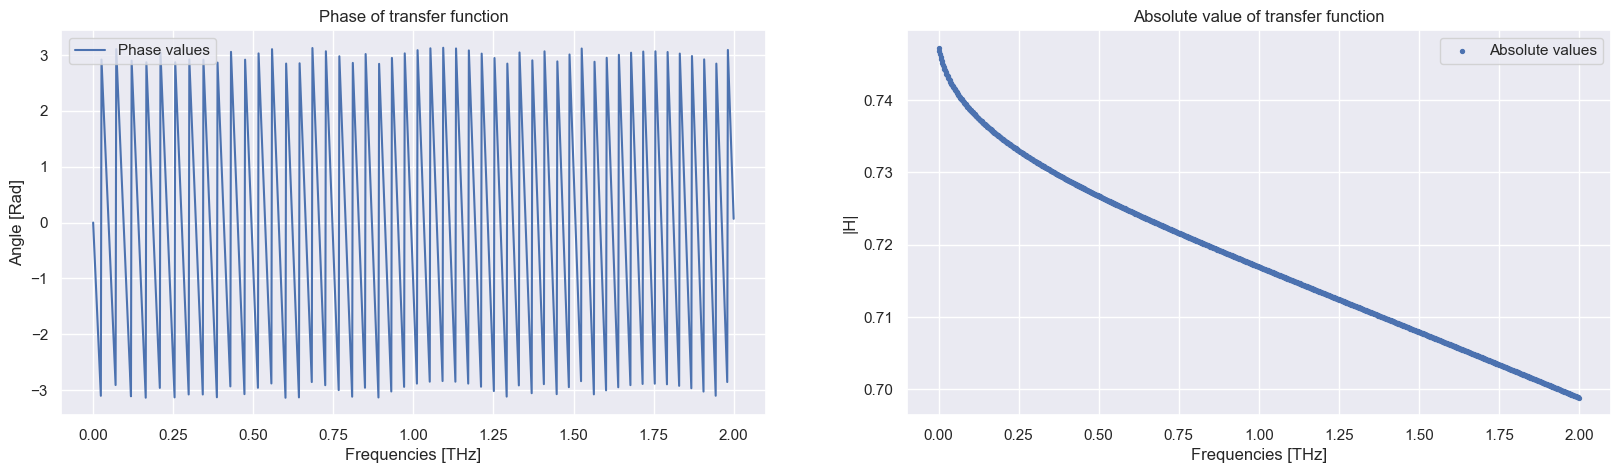

In [11]:
n_complex = n + 1j*k

freq_dep_H = H_th_function(n_complex, w=full_w, length=thickness)

# Break down into components
freq_dep_H_abs = torch.abs(freq_dep_H)
freq_dep_H_phase = torch.angle(freq_dep_H)

plot_transfer(full_w_THz, absolute_values=freq_dep_H_abs, phase_values=freq_dep_H_phase)

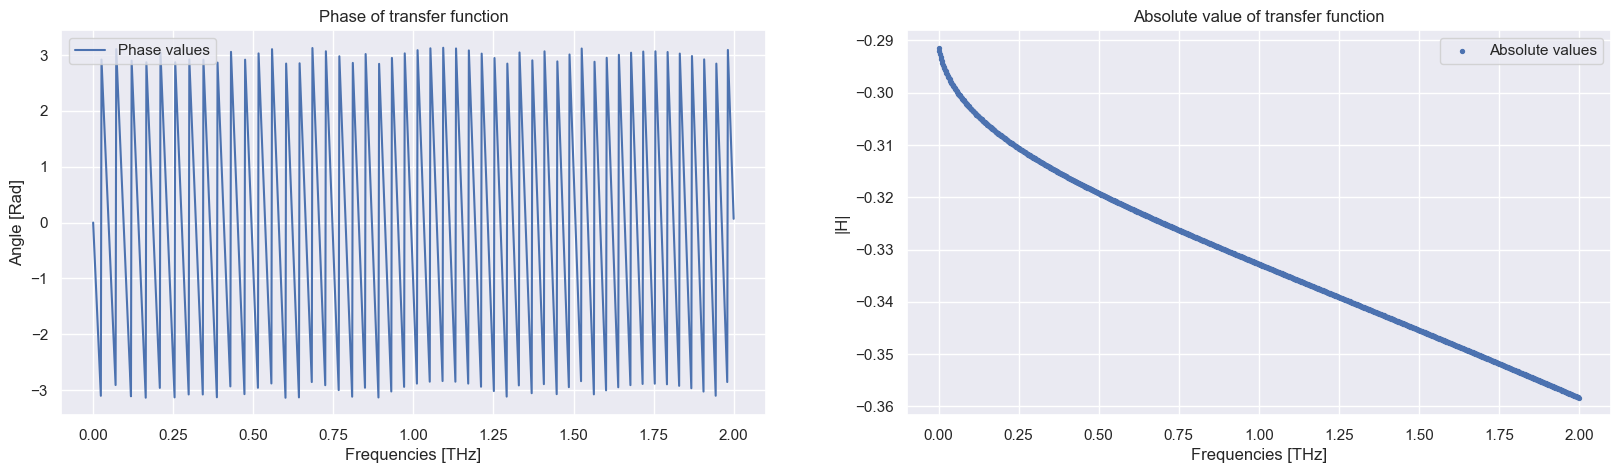

In [12]:
# Plot log of TF
log_TF = torch.log(freq_dep_H)

plot_transfer(full_w_THz, absolute_values=log_TF.real, phase_values=log_TF.imag)


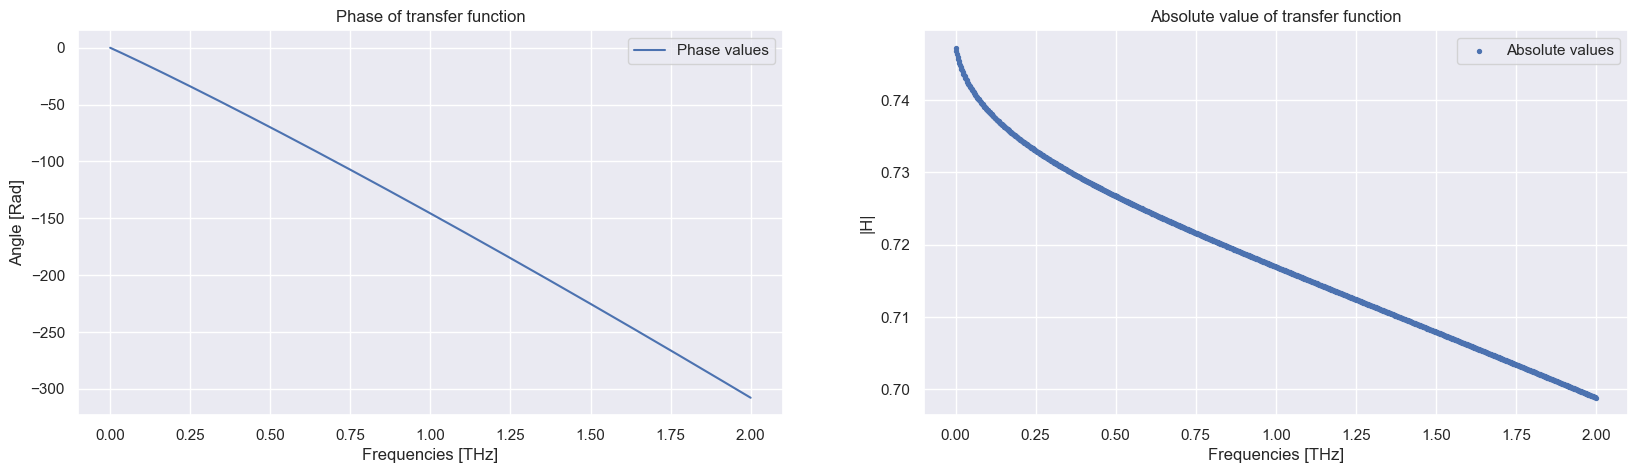

In [13]:
freq_dep_H_phi = torch_unwrap(torch.angle(freq_dep_H))
plot_transfer(full_w_THz, absolute_values=freq_dep_H_abs, phase_values=freq_dep_H_phi)

## Initialize Frequency dependent Model

Epoch 0: Loss = 5.809986591339111 (Best Loss = 5.809986591339111)
Epoch 500: Loss = 0.18488790094852448 (Best Loss = 0.18488790094852448)
Epoch 1000: Loss = 0.07402899861335754 (Best Loss = 0.07402899861335754)
Epoch 1500: Loss = 0.04100119695067406 (Best Loss = 0.04100119695067406)
Epoch 2000: Loss = 0.027542876079678535 (Best Loss = 0.027542876079678535)
Epoch 2500: Loss = 0.020675547420978546 (Best Loss = 0.020675547420978546)


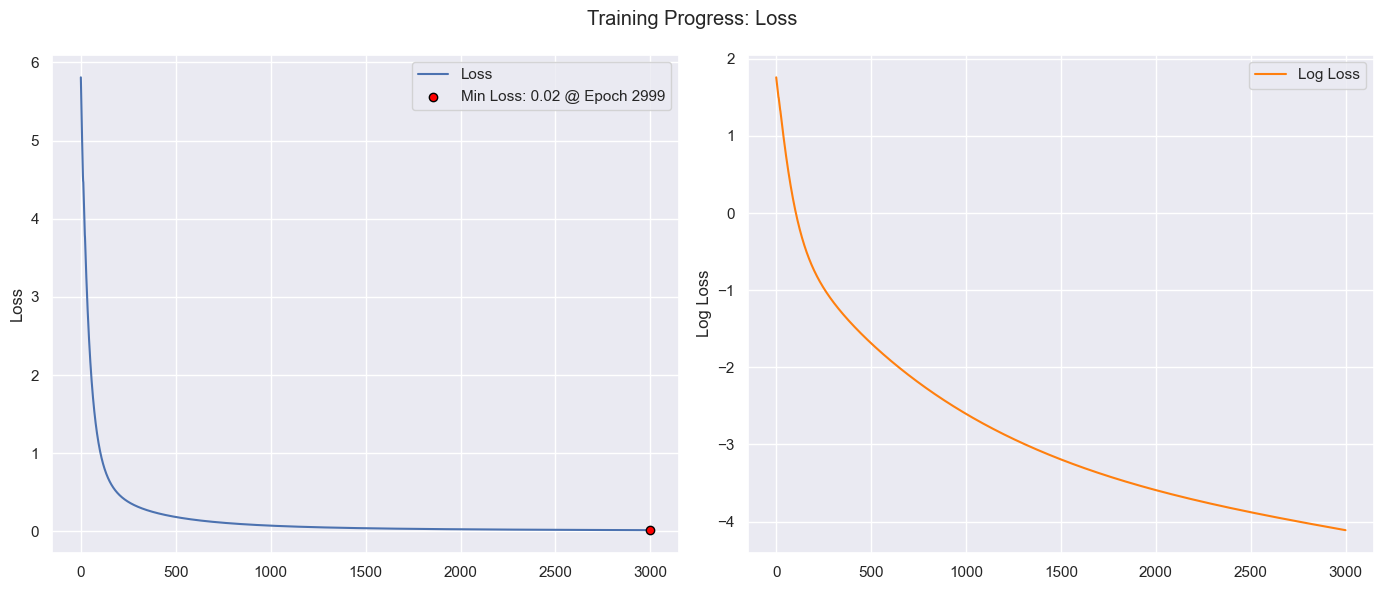

In [14]:
freq_model = FrequencyDependentModel(w_tensor=full_w, d=thickness, ICs_n=3.2, ICs_k=0.0001)

# Setup Optimizer and scheduler
optimizer_freq = torch.optim.Adam(freq_model.parameters(), lr=5e-4)

# Not used at the moment
scheduler_freq = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer_freq, mode='min', factor=0.1, patience=250)


freq_model.train_model(H_exp=freq_dep_H, Physical_model=H_th_function, loss_fn=log_complex_loss, epochs=3000, optimizer=optimizer_freq)
plot_training_progress(freq_model.loss_history)

In [15]:
n_w = freq_model.n.detach().cpu().numpy()
k_w = freq_model.k.detach().cpu().numpy()

frequencies = full_w_THz


def plot_material_params(frequencies, n, k):
    # Create the first subplot (assuming 'data1' is your first dataset)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # First plot: Approximate values of n from NR solution
    sns.scatterplot(x=frequencies, y=n, label="n values", ax=ax1)
    ax1.set_title('Approximate values of n')
    ax1.yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
    ax1.set_xlabel('Frequencies [THz]')

    # Second plot (assuming 'data2' is your second dataset with x and y values)
    sns.scatterplot(x=frequencies, y=k, label="k values", ax=ax2)
    ax2.set_title('Approximate values of k')
    ax2.yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
    ax2.set_xlabel('Frequencies [THz]')

    # Adjust layout and add main title if needed
    plt.suptitle('Material Parameters', y=1.02)
    plt.tight_layout()
    plt.legend()
    plt.show()

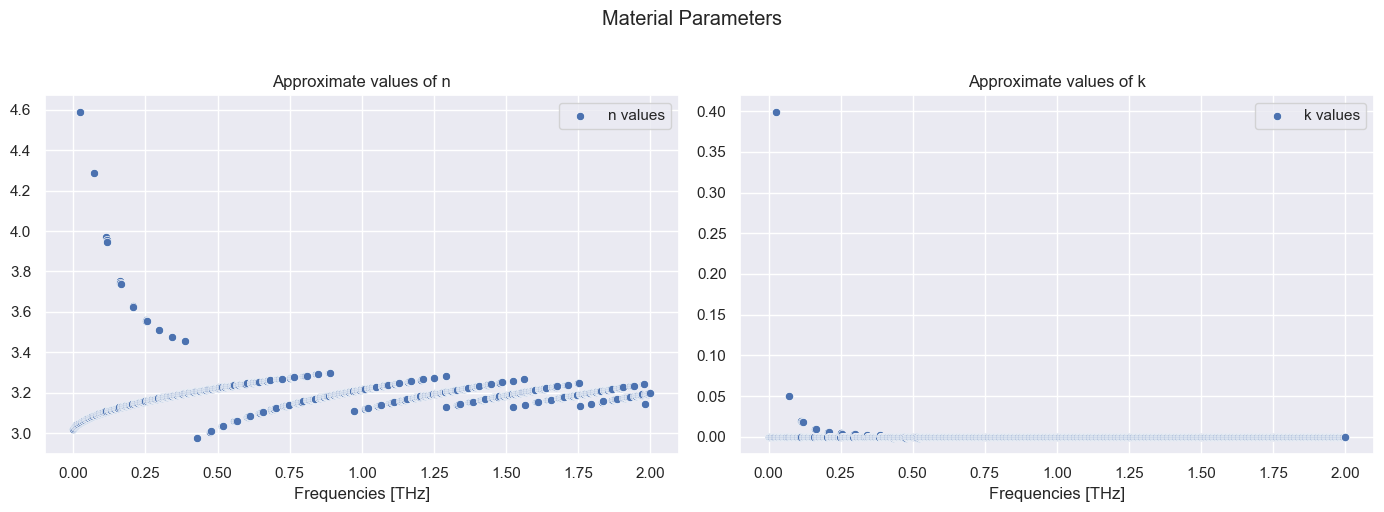

In [16]:
plot_material_params(frequencies=frequencies, n=n_w, k=k_w)

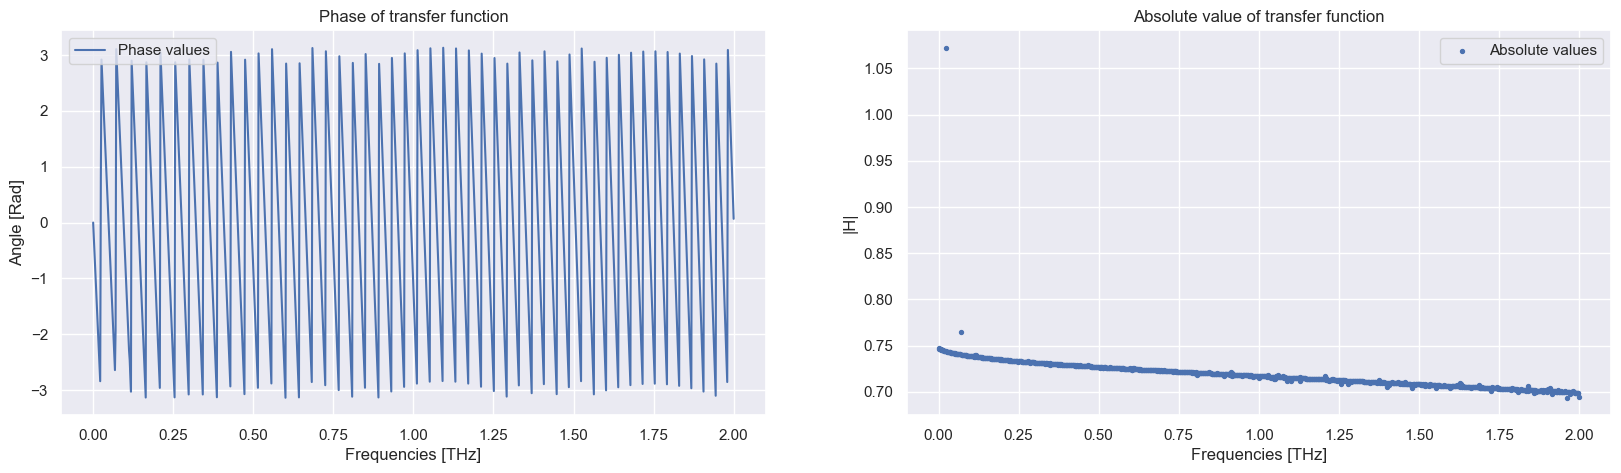

In [17]:
n_complex_w = n_w + 1j*k_w
n_complex_w = torch.tensor(n_complex_w, dtype=torch.cfloat)

H_w_recon = H_th_function(n_complex=n_complex_w, w=full_w, length=thickness)

H_w_recon_abs = torch.abs(H_w_recon)
H_w_recon_phase = torch.angle(H_w_recon)

plot_transfer(frequencies, H_w_recon_abs, H_w_recon_phase)

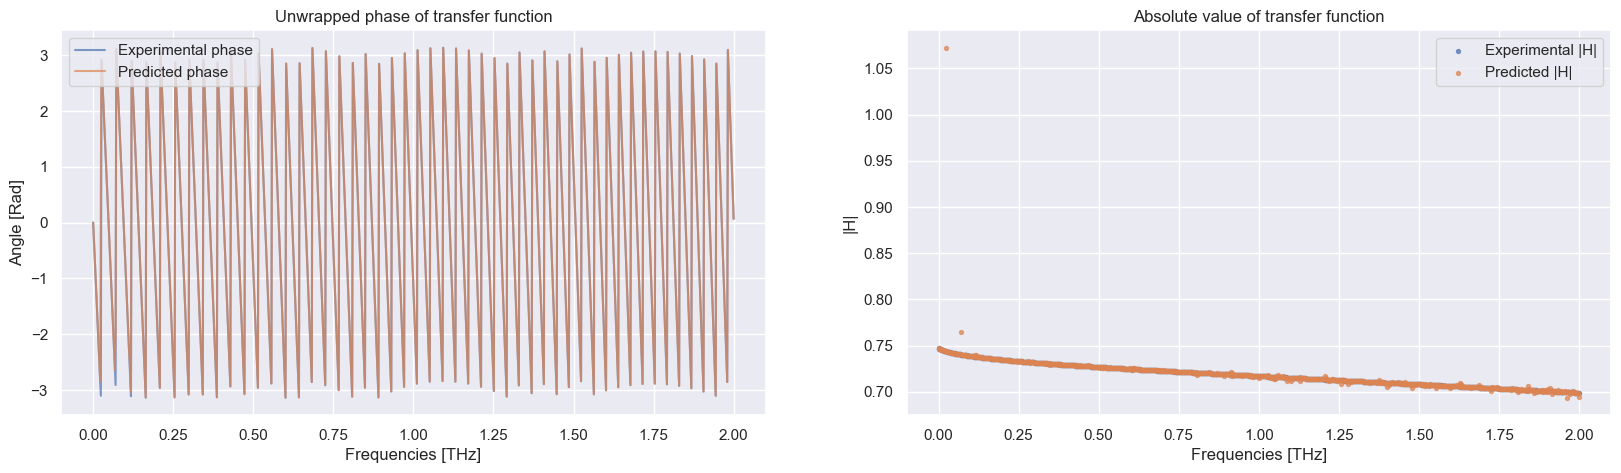

In [18]:
plot_comparison(frequencies=frequencies, exp_abs=freq_dep_H_abs, exp_phase=freq_dep_H_phase, pred_abs=H_w_recon_abs, pred_phase=H_w_recon_phase)